# Basics

Welcome! This tutorial will guide you though the main functions in `asilib`. 

First off, we need to import the necessary packages.

In [1]:
from datetime import datetime, timedelta
from IPython.display import Video
import numpy as np

import matplotlib.pyplot as plt
import asilib
import asilib.asi
import asilib.map

plt.style.use('dark_background')

print(f'asilib version: {asilib.__version__}')

asilib version: 0.23.2


First of all, you should know where the data and movies are saved to. This information is in `asilib.config` and can be changed with `python3 -m asilib config` to configure asilib.

In [2]:
asilib.config

{'ASILIB_DIR': WindowsPath('C:/Users/shumkms1/Documents/research/asilib/asilib'),
 'ASI_DATA_DIR': WindowsPath('C:/Users/shumkms1/asilib-data'),
 'ACKNOWLEDGED_ASIS': []}

As you can guess, `asilib.config['ASILIB_DIR']` is the directory where this code resides, `asilib.config['ASI_DATA_DIR']` is the directory where the data is saved to.

## Plot a single image

The core of asilib is the `asilib.Imager` class. It provides an intuitive interface to load, plot, animate, and analyze auroral images. Normally, you do not need to call `asilib.Imager()` directly. Instead, you initialize an `asilib.Imager` object via a ASI interface function, such as `asilib.asi.themis`, `asilib.asi.rego`, or `asilib.asi.trex_nir`. Let's see how this works by plotting a fisheye lens image from a THEMIS imager at Athabasca (ATHA). We will show the aurora studied in:

Liu, J., Lyons, L. R., Archer, W. E., Gallardo-Lacourt, B., Nishimura, Y., Zou, Y., … Weygand, J. M. (2018). Flow shears at the poleward boundary of omega bands  observed during conjunctions of Swarm and THEMIS ASI. Geophysical Research Letters, 45, 1218– 1227. https://doi.org/10.1002/2017GL076485

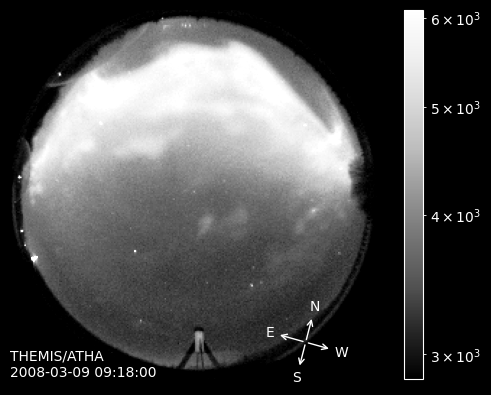

In [3]:
location_code = 'ATHA'
time = datetime(2008, 3, 9, 9, 18, 0)  # You can supply a datetime object or a ISO-formatted time string.

asi = asilib.asi.themis(location_code, time=time)
ax, im = asi.plot_fisheye(cardinal_directions='news')
plt.colorbar(im)
ax.axis('off');

That is it! By calling the `asilib.asi.themis()` function, we create an `asilib.Imager()` object---with uniform interface. In other words, plotting a fisheye image (`Imager.plot_fisheye()`) is the same for THEMIS, REGO, TREx, or any other ASI supported by asilib. This is what makes asilib so powerful.

It is also easy to map the ASI fisheye lens image to a geographic map using the `Imager.plot_map()` method. In the code box below, the first line creates a geographic map centered on Athabasca and the second line projects the image onto the map.

Note: If latitude or longitude bounds are not provided, `Imager.plot_map()` defaults to a map of North America.

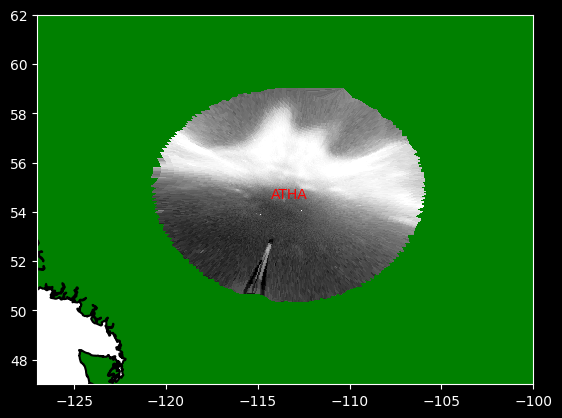

In [4]:
ax = asilib.map.create_simple_map(lon_bounds=(-127, -100), lat_bounds=(47, 62))
asi.plot_map(ax=ax);

Notice that you did not need to explicitly download or load the data. The ASI Interface Function downloads the necessary image and skymap files, while `asilib.Imager()` loads data as needed, also known as the "lazy" mode. This preserves your computer's memory at the expense of processing speed. Alternatively, you can load all of the data into memory at once with the "eager" mode.

In [5]:
asi_data = asi.data

In [6]:
asi_data.time

datetime.datetime(2008, 3, 9, 9, 18, 0, 50605)

In [7]:
asi_data.image.shape

(256, 256)

In [8]:
asi_data.image

array([[2536, 2616, 2554, ..., 2572, 2537, 2546],
       [2582, 2582, 2620, ..., 2562, 2613, 2608],
       [2544, 2560, 2568, ..., 2588, 2526, 2550],
       ...,
       [2525, 2546, 2553, ..., 2612, 2541, 2629],
       [2545, 2596, 2698, ..., 2510, 2568, 2569],
       [2502, 2577, 2602, ..., 2514, 2617, 2576]], dtype=uint16)

## Plot a Keogram

`Imager.plot_keogram()` plots a keogram through the meridian. Alternatively, you can specify a custom path using (latitude, longitude coordinates).

By default, the y-axis is geographic latitude. If you set `aacgm=True`, the keogram's vertical axis will be magnetic latitude estimated using the [aacgmv2](https://github.com/aburrell/aacgmv2) Python package. It implements the Altitude-adjusted corrected geomagnetic coordinates defined in [Shepherd 2014](https://doi.org/10.1002/2014JA020264).

THEMIS ATHA keogram: |##################################################| 100%


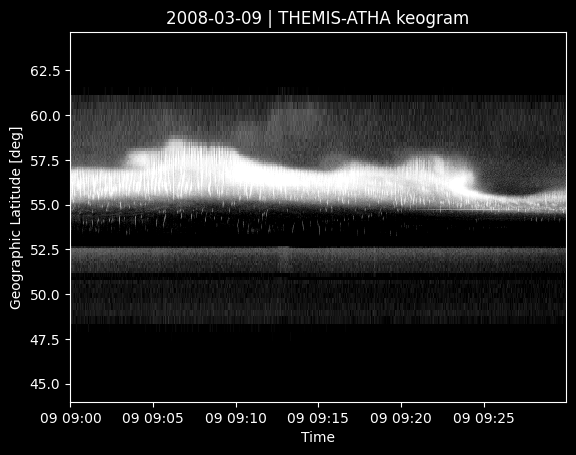

In [9]:
time_range = [datetime(2008, 3, 9, 9, 0, 0), datetime(2008, 3, 9, 9, 30, 0)]
asi2 = asilib.asi.themis(location_code, time_range=time_range)
asi2.plot_keogram()
plt.xlabel('Time'); plt.ylabel('Geographic Latitude [deg]');

THEMIS ATHA keogram: |##################################################| 100%


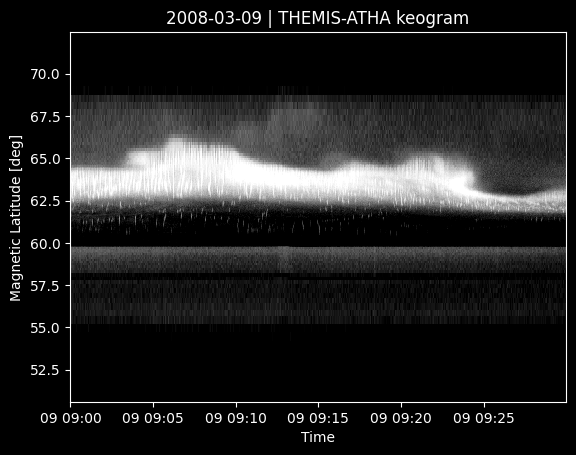

In [10]:
asi2.plot_keogram(aacgm=True)
plt.xlabel('Time'); plt.ylabel('Magnetic Latitude [deg]');

In making the last three plots, the geographic latitudes correspond to pixels mapped to a specified auroral emission altitude. This altitude is set with the `alt` kwarg passed into the ASI Interface Function. The default altitude is 110 km for THEMIS and 230 km for REGO.

If you pick an incorrect `alt`, you will get an error.

In [11]:
try:
    asilib.asi.themis(location_code, time_range=time_range, alt=100)
except AssertionError as err:
    print('AssetionError:', err)

AssetionError: 100 km is not in the valid skymap altitudes: [ 90. 110. 150.] km. If you want a custom altitude with less percision, please use the custom_alt keyword


These auroral emission altitudes are defined in the skymap files.

## Skymap calibration files
You may wonder how the image's pixel values were mapped to geographic latitude. This is done via the skymap calibration files that are provided by the instrument teams. They contain four arrays that map the ASI's pixels to:

- `el` - elevation
- `az` - azimuth
- `lat` - latitude
- `lon` - longitude

These skymaps are essential for mapping images onto a geographic map, and for calculating the auroral intensity for conjunction studies.

In [12]:
asi2.skymap.keys()

dict_keys(['lat', 'lon', 'alt', 'el', 'az', 'path'])

The ASI maintainers often move or adjust their ASIs, after which a new skymap is often produced. Therefore, the relevant skymap is the one taken right before the images that were loaded. By default, asilib downloads all of the skymaps. The skymap file name below indicates that it is valid for images taken between 1 March 2007 and 22 May 2009.

In [13]:
asi2.skymap['path'].name

'themis_skymap_atha_20070301-20090522_vXX.sav'

Lastly, the `Imager` instance has a `meta` attribute that contains the ASI metadata such as location, pixel resolution, and cadence. 

In [14]:
asi2.meta

{'array': 'THEMIS',
 'location': 'ATHA',
 'lat': 54.720001220703125,
 'lon': -113.30999755859375,
 'alt': 0.676,
 'cadence': 3,
 'resolution': (256, 256)}

You can also see human-readable summary of the ASI by printing it.

In [15]:
print(asi2)

A THEMIS-ATHA Imager. time_range=[datetime.datetime(2008, 3, 9, 9, 0), datetime.datetime(2008, 3, 9, 9, 30)]


## Mapping multiple all-sky images

You can plot one image from multiple ASI locations using a for-loop. In the following example, we will replicate Fig. 2b from:

Donovan, E., Liu, W., Liang, J., Spanswick, E., Voronkov, I., Connors, M., ... & Rae, I. J. (2008). Simultaneous THEMIS in situ and auroral observations of a small substorm. Geophysical Research Letters, 35(17).

c:\Users\shumkms1\AppData\Local\anaconda3\envs\asilib_dev_cartopy\Lib\site-packages\scipy\io\_idl.py:279: UserWarning: Not able to verify number of bytes from header
  warnings.warn("Not able to verify number of bytes from header")


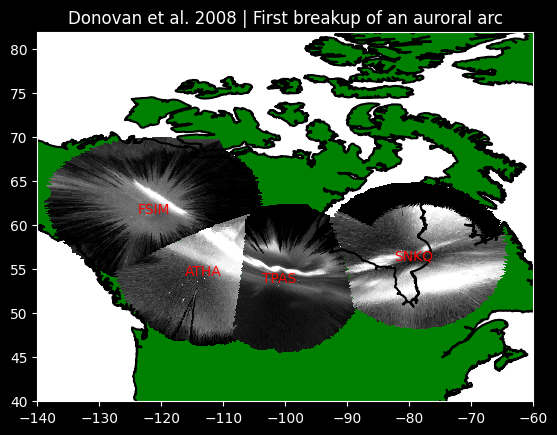

In [16]:
time = datetime(2007, 3, 13, 5, 8, 45)
location_codes = ['FSIM', 'ATHA', 'TPAS', 'SNKQ']
map_alt = 110
min_elevation = 2  # Plot only pixels observed above some minimum elevation.

bx = asilib.map.create_simple_map()

asis = asilib.Imagers(
    [asilib.asi.themis(location_code, time=time, alt=map_alt) for location_code in location_codes]
    )
asis.plot_map(ax=bx, min_elevation=min_elevation)

bx.set_title('Donovan et al. 2008 | First breakup of an auroral arc')
plt.show()

## Working with multiple images

`asilib.Imager` supports slicing by time. In the example below, we plot a few fisheye and mapped images of STEVE that was observed by the REGO imagers.

Gallardo-Lacourt, B., Nishimura, Y., Donovan, E., Gillies, D. M., Perry, G. W., Archer, W. E., et al. (2018). A statistical analysis of STEVE. Journal of Geophysical Research: Space Physics, 123, 9893– 9905. https://doi.org/10.1029/2018JA025368

Redline Emission Geospace Observatory (REGO) data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset. Please see below for the required data acknowledgement. Any questions about the REGO instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

"The Redline Emission Geospace Observatory (REGO) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. REGO is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC]."


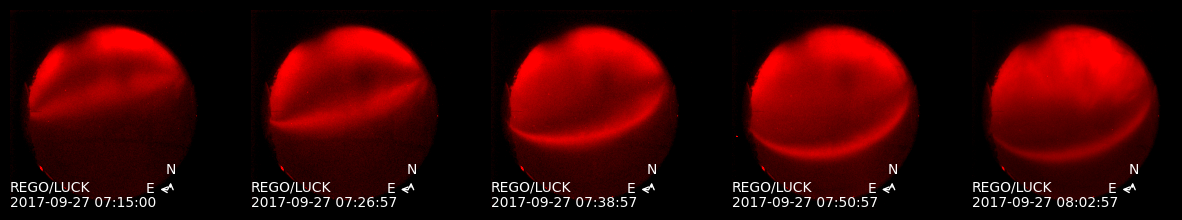

In [17]:
time_range = [datetime(2017, 9, 27, 7, 15), datetime(2017, 9, 27, 8, 15)]
n_plots = 5
dt = int((time_range[1]-time_range[0]).total_seconds()/n_plots)
image_times = [time_range[0]+timedelta(seconds=i*dt) for i in range(n_plots)]

asi = asilib.asi.rego('LUCK', time_range=time_range)

fig, cx = plt.subplots(1, n_plots, figsize=(15, 8))

for montage_time, cx_i in zip(image_times, cx):
    filtered_asi = asi[montage_time]
    filtered_asi.plot_fisheye(ax=cx_i)
    cx_i.axis('off')

## Animate images

Let's now make a simple fisheye lens movie of a substorm using `Imager.animate_fisheye()`.

In [18]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)
asi.animate_fisheye(overwrite=True, ffmpeg_params={'loglevel':'quiet'})
plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/asilib/raw/main/docs/_static/example_outputs/20150326_060700_063000_themis_fsmi_fisheye.mp4')

20150326_060700_063000_themis_fsmi_fisheye.mp4: |#######################| 100%
Animation saved to C:\Users\shumkms1\asilib-data\animations\20150326_060700_063000_themis_fsmi_fisheye.mp4


Animating images projected onto a map is also straightforward. 

In [20]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)

lat_bounds = (asi.meta['lat']-7, asi.meta['lat']+7)
lon_bounds = (asi.meta['lon']-10, asi.meta['lon']+10)

dx = asilib.map.create_simple_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
plt.subplots_adjust(top=0.99, bottom=0.05, left=0.05, right=0.99)

asi.animate_map(overwrite=True, ax=dx, ffmpeg_params={'loglevel':'quiet'})

plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/animations directory.
Video('https://github.com/mshumko/asilib/raw/main/docs/_static/example_outputs/20150326_060700_061200_themis_fsmi_map.mp4')

20150326_060700_063000_themis_fsmi_map.mp4: |###########################| 100%
Animation saved to C:\Users\shumkms1\asilib-data\animations\20150326_060700_063000_themis_fsmi_map.mp4


If you need to annotate the animation, `asilib.Imager` has `animate_fisheye_gen` and `animate_map_gen` generator functions. After it plots each auroral image, it allows you to superpose your data.

Note: in each iteration, these methods do not clear the subplot; all plot objects persist unless you explicitly remove them 

In [22]:
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 10, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asi = asilib.asi.themis(location_code, time_range=time_range)

lat_bounds = (asi.meta['lat']-7, asi.meta['lat']+7)
lon_bounds = (asi.  meta['lon']-10, asi.meta['lon']+10)

ex = asilib.map.create_simple_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
plt.subplots_adjust(top=0.99, bottom=0.05, left=0.05, right=0.99)
gen = asi.animate_map_gen(overwrite=True, ax=ex, ffmpeg_params={'loglevel':'quiet'}, asi_label=False)

for time, image, ax, im in gen:
    if 'time_label' in locals():
        # This is one way I found to clean up an added plotting object. 
        time_label.remove()
    time_label = ex.text(0.99, 0.99, f'location: {location_code} | time: {time}', 
                         ha='right', va='top', transform=ex.transAxes, fontsize=15)

plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/animations directory.
Video('https://github.com/mshumko/asilib/raw/main/docs/_static/example_outputs/20150326_061000_063000_themis_fsmi_map.mp4')

20150326_061000_063000_themis_fsmi_map.mp4: |###########################| 100%
Animation saved to C:\Users\shumkms1\asilib-data\animations\20150326_061000_063000_themis_fsmi_map.mp4
